In [ ]:
import numpy as np

from glob import glob
import matplotlib.pyplot as plt
import os
import pandas as pd

from PIL import Image
from skimage import io, color, img_as_float, img_as_ubyte
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!pip install torchinfo
from torchinfo import summary

#
# install grad-cam library 
# https://github.com/jacobgil/pytorch-grad-cam
#
!pip install grad-cam
from pytorch_grad_cam import GradCAM

!nvidia-smi

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Wed Jan 11 11:16:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.34       Driver Version: 430.34       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 27%   54C    P2    63W / 250W |   1670MiB / 11019MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 24%   41C    P8     6W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+---

In [ ]:
!python --version

root_path = "/media/kondo/Ext4_for_Colab/tomizawa/paper/" #@param {type:"string"}
#@markdown  - Assign a path for your root directory. This root directory should include an image dataset directory ("/data/data_original/") and "/utils/" directory.
#@markdown  - The image dataset is available at a database (URL in #README on the GitHub).
#@markdown  - The library "utils" is available at the same GitHub page with this jupyter notebook.

%cd $root_path 
!pwd
!ls

In [ ]:
from utils.loaders import Args, ImageTransform, MarchantiaDataset, get_data, indices_to_loader
from utils.misc import get_unnormalize, get_datetime, makedirs, set_requires_grad_toFalse, train_model_pytorch_tutorial, compute_loss
from utils.misc import visualize_batch
from utils.misc import display_loss_acc, predict_testloader, test_loadedModel

from utils.cams import GradCAM_withGrad, calculate_cam, input_to_img
from utils.cams import get_cam_visualizations, get_cam_visualizations_withGrad, plot_cam_results, plot_gradients_activations
from utils.camCondition import CamConditionContainer

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [ ]:
def plot_cam_results(img, label, pred, visualizations, strain):
    ## label & pred from 0/1 to F/M
    if strain == 'Tak':
      label_FM = "F" if label == 1 else "M" if label == 0 else None
      pred_FM = "F" if pred == 1 else "M" if pred == 0 else None
      
      fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
      ax[0].imshow(img)
      ax[0].set_title("True label: " + label_FM + ", prediction: " + pred_FM)
      ax[0].axis('off')
      ax[1].imshow(visualizations[1]) #Tak : class1=F
      ax[1].set_title("Grad-CAM for label F")
      ax[1].axis('off')
      ax[2].imshow(visualizations[0]) #Tak : class0=M
      ax[2].set_title("Grad-CAM for label M")
      ax[2].axis('off')

    else:
      label_FM = "F" if label == 0 else "M" if label == 1 else None
      pred_FM = "F" if pred == 0 else "M" if pred == 1 else None
      
      fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
      ax[0].imshow(img)
      ax[0].set_title("True label: " + label_FM + ", prediction: " + pred_FM)
      ax[0].axis('off')
      ax[1].imshow(visualizations[0])
      ax[1].set_title("Grad-CAM for label F")
      ax[1].axis('off')
      ax[2].imshow(visualizations[1])
      ax[2].set_title("Grad-CAM for label M")
      ax[2].axis('off')
    


from typing import NamedTuple
from utils.cams import get_cam_visualizations#, plot_cam_results
class CamConditionContainer(NamedTuple):
    correct: bool
    pred_label: str
    logits_best: bool

        
    def get_conditioned_indices(self, outputs, labels, strain):
        '''正解・不正解、オス・メスを絞り込み'''
        preds = np.argmax(outputs, axis=1)
        outputs_sub = outputs[:, 0] - outputs[:,1]
        cond1 = (preds == labels) if self.correct==True else (preds != labels) if self.correct==False else None
        if strain == 'Tak':
          cond2 = (outputs_sub < 0) if self.pred_label == 'F' else (outputs_sub > 0) if self.pred_label == 'M' else None# if self.pred_label ==None
        else:
          cond2 = (outputs_sub > 0) if self.pred_label == 'F' else (outputs_sub < 0) if self.pred_label == 'M' else None# if self.pred_label ==None
        conditioned_indices = np.where(cond1 & cond2)
        return conditioned_indices

       
    def data_subsets_sorted(self, outputs, labels, inputs):
        '''条件で絞り込んだ部分集合データセットを作成＆ソート'''
        idx = self.get_conditioned_indices(outputs, labels, strain)
        preds = np.argmax(outputs, axis=1)
        outputs_sub = outputs[:, 0] - outputs[:,1]
        inputs_small, labels_small, outputs_sub_small, outputs_small, preds_small = inputs[idx], labels[idx], outputs_sub[idx], outputs[idx], preds[idx]
        indices_sorted = np.argsort(np.abs(outputs_sub_small))[::-1] if self.logits_best == True else np.argsort(np.abs(outputs_sub_small)) if self.logits_best == False else None
        return indices_sorted, inputs_small, labels_small, outputs_small, outputs_sub_small

        
    def plot_best_heatmaps(self, outputs, labels, inputs, cam, dev, args, strain,
                           N_plot=3, save=True):
        '''最初のN_plot個をプロット'''
        indices_sorted, inputs_small, labels_small, outputs_small, outputs_sub_small = self.data_subsets_sorted(outputs, labels, inputs)
        preds_small = np.argmax(outputs_small, axis=1)
        print(self)
        if N_plot <= indices_sorted.shape[0]: 
            for n in range(N_plot):
                i = indices_sorted[n]
                input = inputs_small[i:i+1, :, :, :]
                label = labels_small[i]
                pred = preds_small[i]
                output = outputs_small[i]
                rgb_img, visualizations = get_cam_visualizations(torch.from_numpy(input).clone().to(dev), cam)
                print('output:', output)
                plot_cam_results(rgb_img, label, pred, visualizations, strain)
                if save==True:
                    sorting = 'best' if self.logits_best == True else 'worst'
                    plt.savefig(f'{args.figure_path}heatmap_pred{self.pred_label}_corr{self.correct}_{sorting}{n+1}.png')
                    plt.savefig(f'{args.figure_path}heatmap_pred{self.pred_label}_corr{self.correct}_{sorting}{n+1}.pdf')
                plt.show()
        else:
            print('Not enough samples ', indices_sorted.shape[0])

{'size_image': 224, 'batch_size': 32, 'root': './data/data_original/Tak/0d'}
['./results_test/20221228-024951_Tak_0d_original/', './results_test/20221228-031701_Tak_0d_original/', './results_test/20221228-034229_Tak_0d_original/', './results_test/20221228-040917_Tak_0d_original/', './results_test/20221228-043632_Tak_0d_original/', './results_test/20221230-074711_Tak_0d_blur/', './results_test/20221230-080755_Tak_0d_blur/', './results_test/20221230-082855_Tak_0d_blur/', './results_test/20221230-084936_Tak_0d_blur/', './results_test/20221230-091030_Tak_0d_blur/', './results_test/20230101-030105_Tak_0d_mask/', './results_test/20230101-032146_Tak_0d_mask/', './results_test/20230101-034226_Tak_0d_mask/', './results_test/20230101-040258_Tak_0d_mask/', './results_test/20230101-042336_Tak_0d_mask/', './results_test/20230103-004653_Tak_0d_black-back/', './results_test/20230103-011412_Tak_0d_black-back/', './results_test/20230103-014114_Tak_0d_black-back/', './results_test/20230103-020715_Tak_0d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


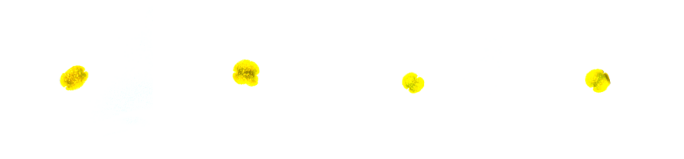

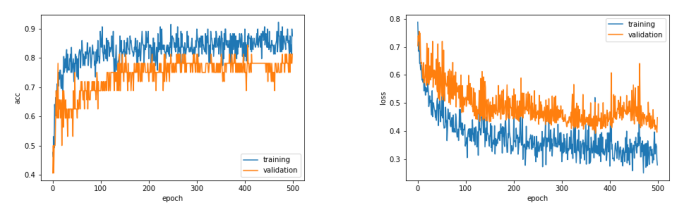

epoch with max validation acc. : 406
loss : 0.44066745042800903, acc : 0.84375
(40,)
test_acc :  0.85


In [ ]:
# load models
strain = 'Tak'#'RIL5','Aus' 
day = '0d'
ablation = 'original_noScaleBar'
multilabel = False

### data
args = Args()
args.root =  './data/data_' + ablation + '/' + strain + '/' + day
print(args.__dict__)

### outputs (results of CAM)
figures_rootpath = './figures/forGitHub/GradCAM/'
figures_path = figures_rootpath + strain + '_' + day + '_' + ablation +  '_multilabel' + '/' if multilabel else figures_rootpath + strain + '_' + day + '_' + ablation +  '/'
makedirs(figures_path)
args.figure_path = figures_path

### model
model_path = glob('./results_multilabels' + '/*_' + strain + '_' + day + '*/') if multilabel else glob('./results_forGitHub' + '/*_' + strain + '_' + day + '*/') if ablation == 'original_noScaleBar' else glob('./results_forGitHub' + '/*_' + strain + '_' + day + '_' + ablation + '*/')
model_path.sort()
print(model_path)
model_path = model_path[0]
args.model_path = model_path

model_fname = glob(args.model_path + '*.pt')[0]
args.model_fname = model_fname
print(args.__dict__)
########################

# load a model
model = resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(args.model_fname, map_location=torch.device('cpu')))
model.to(dev);

# load a dataset
Transform = ImageTransform(fill=0)
full_dataset = ImageFolder(root=args.root)
print(full_dataset)
print(full_dataset.class_to_idx)
dataset_noaug = MarchantiaDataset(full_dataset, Transform.data_transform["valid"])
val_loader = indices_to_loader(args.model_path, 'indices_val.csv', dataset_noaug, batch_size=args.batch_size)
test_loader = indices_to_loader(args.model_path, 'indices_test.csv', dataset_noaug, batch_size=args.batch_size)

test_images, _ = next(iter(test_loader))
visualize_batch(test_images); plt.show()

display_loss_acc(args.model_path); plt.show()
test_loadedModel(args.model_path, model, val_loader, dev, multilabel=multilabel)

inputs_test, labels_test, outputs_test, preds_test = predict_testloader(model, test_loader, dev)
print(preds_test.shape)
print('test_acc : ', preds_test[preds_test == labels_test].shape[0]/preds_test.shape[0])

In [ ]:
model.train()
unnormalize = get_unnormalize()

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
print('compute gradients : ', cam.compute_input_gradient)

cam_grads = GradCAM_withGrad(model=model, target_layers=target_layers)
print('compute gradients : ', cam_grads.compute_input_gradient)


compute gradients :  False
compute gradients :  True


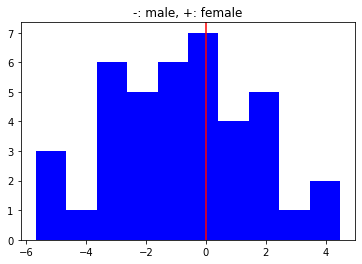

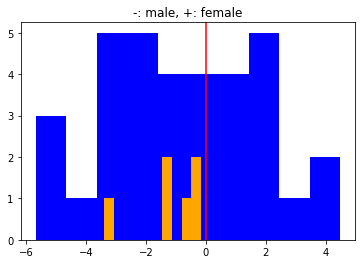

In [ ]:
### histogram, class0 - class1. '-: male, +: female'←Aus, RIL cf.) Tak-1/Tak-2 has ± inversed outputs.
outs = outputs_test # before softmax
outs_sub = outs[:, 0] - outs[:,1]
plt.figure()
plt.hist(outs_sub, color ='blue', label='correct')
plt.axvline(0, color='red')
plt.title('-: male, +: female')
plt.savefig(f'{figures_path}histogram_all.png')
plt.savefig(f'{figures_path}histogram_all.pdf')

plt.show()


plt.figure()
plt.hist(outs_sub[np.argmax(outs, axis=1) == labels_test], color ='blue', label='correct')
plt.hist(outs_sub[np.argmax(outs, axis=1) != labels_test], color ='orange', label='incorrect')
plt.axvline(0, color='red')
plt.title('-: male, +: female')
plt.savefig(f'{figures_path}histogram_2colors.png')
plt.savefig(f'{figures_path}histogram_2colors.pdf')
plt.show()


CamConditionContainer(correct=True, pred_label='F', logits_best=True)
output: [-2.6419082  3.0267568]


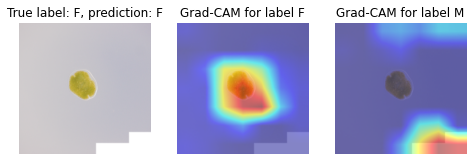

output: [-2.679989   2.7328243]


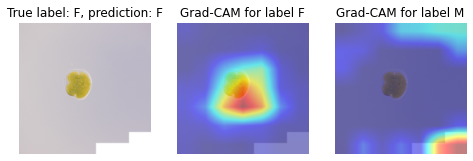

output: [-2.3156734  2.6811132]


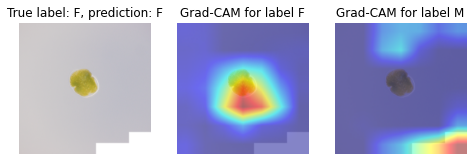

CamConditionContainer(correct=True, pred_label='M', logits_best=True)
output: [ 2.3337078 -2.1429172]


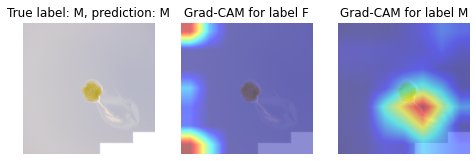

output: [ 2.286972 -1.925985]


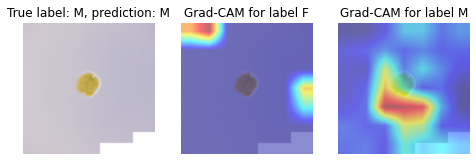

output: [ 1.5460241 -0.9657962]


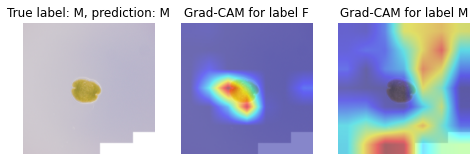

In [ ]:
## 1. correct, [F, M], confident
## map area of correct (predicted) label > incorrect (the other) label
condition = CamConditionContainer(correct=True, pred_label='F', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)


condition = CamConditionContainer(correct=True, pred_label='M', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

CamConditionContainer(correct=True, pred_label='M', logits_best=True)
output: [ 2.3337078 -2.1429172]


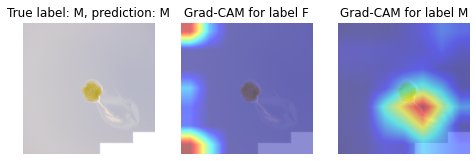

output: [ 2.286972 -1.925985]


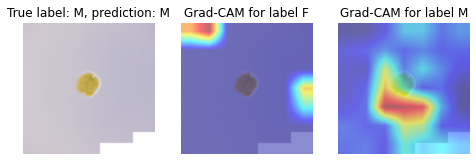

output: [ 1.5460241 -0.9657962]


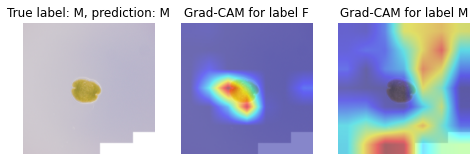

CamConditionContainer(correct=True, pred_label='M', logits_best=False)
output: [0.1759845 0.1087759]


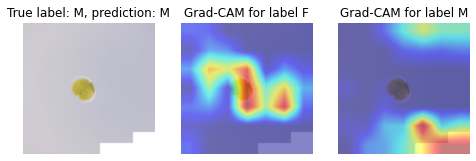

output: [0.3029381  0.02534919]


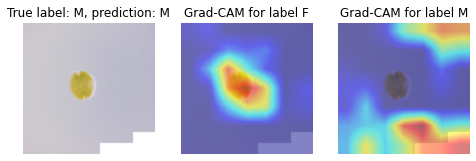

output: [ 0.3427095  -0.19755474]


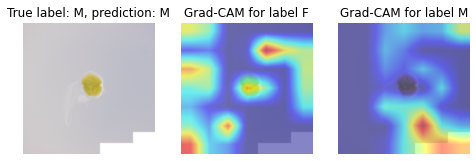

In [ ]:
## 2 correct, M, [confident, not confident]
## larger area when confident, with heatmap intensity in background area
condition = CamConditionContainer(correct=True, pred_label='M', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

condition = CamConditionContainer(correct=True, pred_label='M', logits_best=False)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

CamConditionContainer(correct=True, pred_label='F', logits_best=True)
output: [-2.6419082  3.0267568]


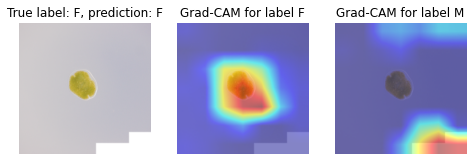

output: [-2.679989   2.7328243]


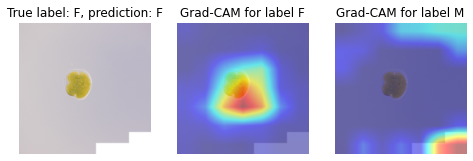

output: [-2.3156734  2.6811132]


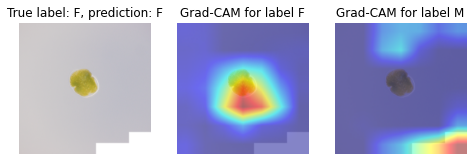

CamConditionContainer(correct=True, pred_label='F', logits_best=False)
output: [-0.12053609  0.38882455]


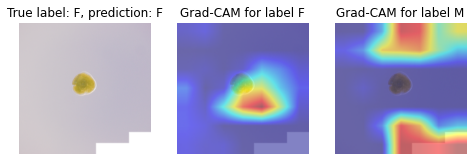

output: [-0.23311108  0.29550338]


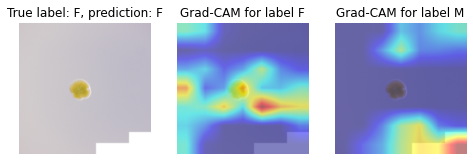

output: [-0.14755422  0.45421174]


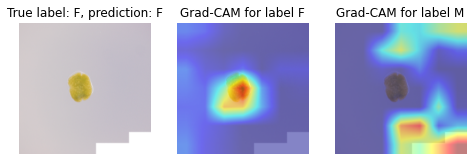

In [ ]:
## 2' correct, F, [confident, not confident]
condition = CamConditionContainer(correct=True, pred_label='F', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

condition = CamConditionContainer(correct=True, pred_label='F', logits_best=False)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

CamConditionContainer(correct=True, pred_label='F', logits_best=True)
output: [-2.6419082  3.0267568]


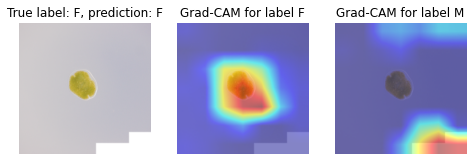

output: [-2.679989   2.7328243]


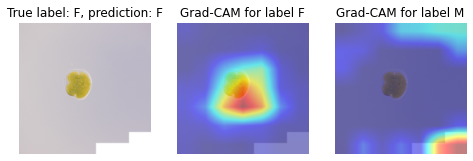

output: [-2.3156734  2.6811132]


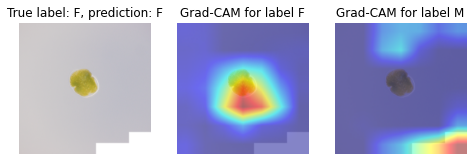

CamConditionContainer(correct=False, pred_label='F', logits_best=True)
output: [-1.5139624  1.865297 ]


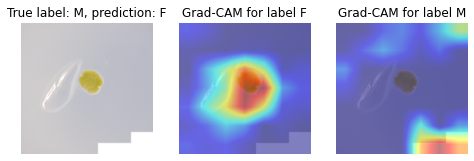

output: [-0.40660456  0.90412384]


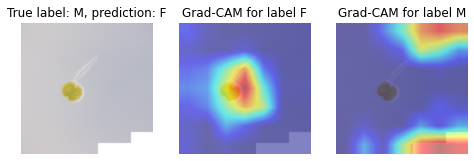

output: [-0.5175422   0.75718147]


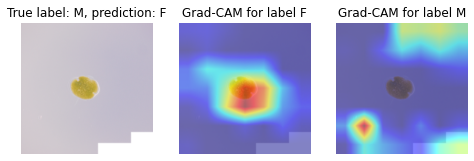

In [ ]:
## 3 [correct, incorrect], prediction F, confident
condition = CamConditionContainer(correct=True, pred_label='F', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

condition = CamConditionContainer(correct=False, pred_label='F', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

CamConditionContainer(correct=True, pred_label='M', logits_best=True)
output: [ 2.3337078 -2.1429172]


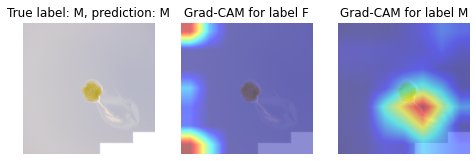

output: [ 2.286972 -1.925985]


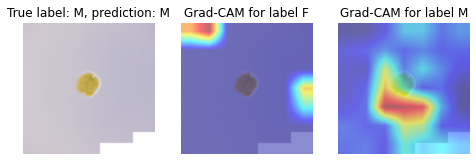

output: [ 1.5460241 -0.9657962]


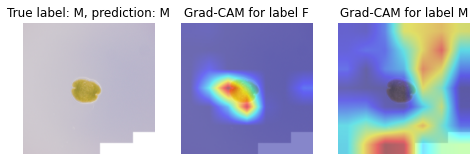

CamConditionContainer(correct=False, pred_label='M', logits_best=True)
Not enough samples  0


In [ ]:
## 3' [correct, incorrect], prediction M, confident
condition = CamConditionContainer(correct=True, pred_label='M', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

condition = CamConditionContainer(correct=False, pred_label='M', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)


CamConditionContainer(correct=False, pred_label='F', logits_best=True)
output: [-1.5139624  1.865297 ]


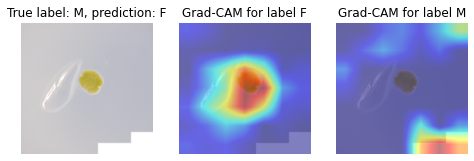

output: [-0.40660456  0.90412384]


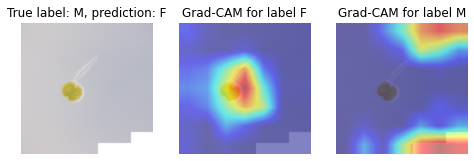

output: [-0.5175422   0.75718147]


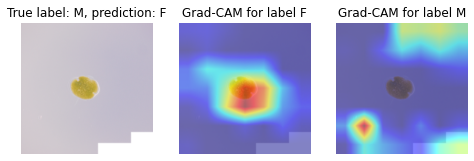

CamConditionContainer(correct=False, pred_label='F', logits_best=False)
output: [0.24359265 0.40673998]


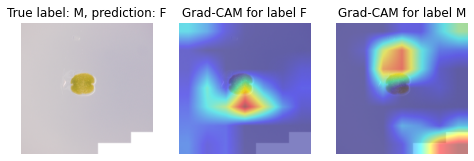

output: [0.22455643 0.40554297]


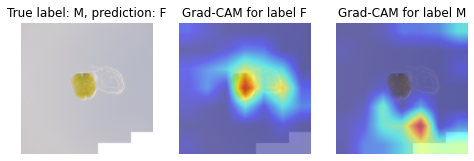

output: [-0.05827091  0.5129182 ]


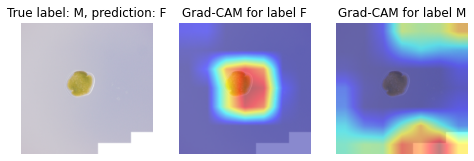

In [ ]:
## 4 incorrect, prediction F, [confident, not confident]

condition = CamConditionContainer(correct=False, pred_label='F', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

condition = CamConditionContainer(correct=False, pred_label='F', logits_best=False)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)


In [ ]:
## 4' incorrect, prediction M, [confident, not confident]

condition = CamConditionContainer(correct=False, pred_label='M', logits_best=True)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)

condition = CamConditionContainer(correct=False, pred_label='M', logits_best=False)
condition.plot_best_heatmaps(outputs_test, labels_test, inputs_test, cam, dev, args, strain)


CamConditionContainer(correct=False, pred_label='M', logits_best=True)
Not enough samples  0
CamConditionContainer(correct=False, pred_label='M', logits_best=False)
Not enough samples  0


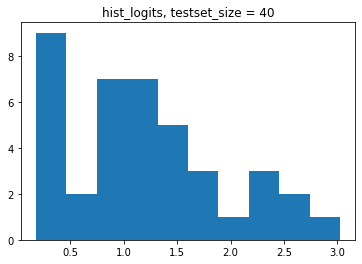

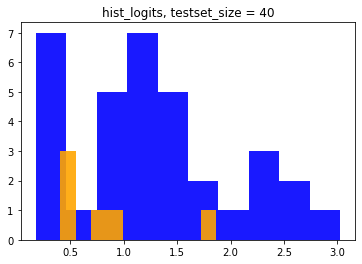

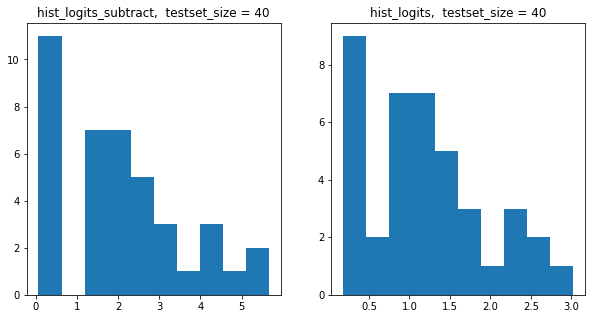

In [ ]:
### histogram -- larger class scores
max_logits = np.max(outputs_test, axis=1)
plt.figure() 
plt.hist(max_logits)
plt.title(f'hist_logits, testset_size = {preds_test.shape[0]}')
# plt.savefig(f'{figures_path}hist_logits.png', dpi=300)
# plt.savefig(f'{figures_path}hist_logits.pdf', dpi=300)
plt.show()


plt.figure() 
plt.hist(max_logits[preds_test == labels_test], color ='blue', alpha=0.9)
plt.hist(max_logits[preds_test != labels_test], color ='orange', alpha=0.9)
plt.title(f'hist_logits, testset_size = {preds_test.shape[0]}')
plt.show()



### histogram -- logits subtraction
max_logits = np.max(outputs_test, axis=1) 
min_logits = np.min(outputs_test, axis=1) 
logits_sub = max_logits - min_logits

fig, ax = plt.subplots(1,2, figsize =(10,5))
ax[0].hist(logits_sub)
ax[0].set_title(f'hist_logits_subtract,  testset_size = {preds_test.shape[0]}')
ax[1].hist(max_logits)
ax[1].set_title(f'hist_logits,  testset_size = {preds_test.shape[0]}')
plt.show()

